In [3]:
import h5py
import numpy as np
from sklearn.preprocessing import StandardScaler

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [4]:
import sklearn
print(sklearn.__version__)

0.24.2


In [5]:
# ef["layer_0"].astype('float32')
# type(ef["layer_0"].astype('float32')[1,1,1])

In [13]:
ef = h5py.File('/raid/javier/Datasets/CaloVAE/data/calo/eplus.hdf5','r')
gf = h5py.File('/raid/javier/Datasets/CaloVAE/data/calo/gamma.hdf5','r')
pf = h5py.File('/raid/javier/Datasets/CaloVAE/data/calo/piplus.hdf5','r')

IsADirectoryError: [Errno 21] Unable to open file (file read failed: time = Mon May 27 13:50:31 2024
, filename = '/fast_scratch/QVAE/data/atlas_dataset2and3', file descriptor = 58, errno = 21, error message = 'Is a directory', buf = 0x7ffd86bb4db8, total read size = 8, bytes this sub-read = 8, bytes actually read = 18446744073709551615, offset = 0)

In [ ]:
hdfs = [ef, gf, pf]
nplcats = []

for hdf in hdfs:
    npl0 = np.array(hdf['layer_0']).astype('float32')
    npl1 = np.array(hdf['layer_1']).astype('float32')
    npl2 = np.array(hdf['layer_2']).astype('float32')
    
    npl0 = npl0.reshape(npl0.shape[0], -1)
    npl1 = npl1.reshape(npl1.shape[0], -1)
    npl2 = npl2.reshape(npl2.shape[0], -1)
    
    nplcats.append(np.concatenate([npl0, npl1, npl2], axis=1))

In [ ]:
nplcatscaled = []
transformers = []
arrmins = [[], [], []]
epsilon = 1e-2

for i in range(len(nplcats)):
    nparr = nplcats[i]
    nparr = np.where(nparr > 0., nparr, np.nan)
    transformer = StandardScaler().fit(nparr)
    nparr = transformer.transform(nparr)
    transformers.append(transformer)
    
    nparr = np.where(np.isnan(nparr), np.inf, nparr)
    
    for j in range(nparr.shape[1]):
        arrmin = np.amin(nparr[:, j])
        
        if arrmin < 0 and not np.isnan(arrmin):
            nparr[:, j] -= arrmin
            nparr[:, j] += epsilon
            arrmins[i].append(arrmin)
        else:
            arrmins[i].append(0.)
            
    nparr = np.where(np.isinf(nparr), 0, nparr)
    
    for j in range(nparr.shape[1]):
        arrmin = np.amin(nparr[:, j])
        if arrmin < 0:
            print(j, arrmin)
            
    nplcatscaled.append(nparr)

In [ ]:
nplcats[2].shape
nplcatscaled[2].shape

In [ ]:
ef_scaled = h5py.File('/raid/javier/Datasets/CaloVAE/data/calo_scaled/eplus.hdf5','w')
gf_scaled = h5py.File('/raid/javier/Datasets/CaloVAE/data/calo_scaled/gamma.hdf5','w')
pf_scaled = h5py.File('/raid/javier/Datasets/CaloVAE/data/calo_scaled/piplus.hdf5','w')

In [ ]:
hdfs_scaled = [ef_scaled, gf_scaled, pf_scaled]
layer_shapes = {}
for key in hdf.keys():
    if key == "energy" or key == "overflow":
        pass
    else:
        layer_shapes[key] = hdf[key].shape

In [ ]:
layer_shapes

In [ ]:
for hdf, hdf_scaled, scaled_data in zip(hdfs, hdfs_scaled, nplcatscaled):
    offset = 0
    for key in hdf.keys():
        if key == "energy" or key == "overflow":
            hdf_scaled.create_dataset(key, data=hdf[key])
        else:
            layer_shape = layer_shapes[key]
            print(scaled_data.shape)
            layer_data = scaled_data[:, offset:offset+(layer_shape[1]*layer_shape[2])]
            print(layer_data.shape)
            layer_data = layer_data.reshape(layer_shape)
            hdf_scaled.create_dataset(key, data=layer_data)
            offset += layer_shape[1]*layer_shape[2]

In [ ]:
for hdf_scaled in hdfs_scaled:
    for key in hdf_scaled.keys():
        print(key, hdf_scaled[key].shape, hdf_scaled[key].dtype)

In [ ]:
for hdf_scaled in hdfs_scaled:
    hdf_scaled.close()

In [ ]:
for nplcat in nplcatscaled:
    print(nplcat.shape)

In [ ]:
print(len(arrmins[0]))

In [ ]:
np.sum(nplcatscaled[2] == np.nan)

In [ ]:
nplcatinv = []

for i in range(len(nplcatscaled)):
    nparr = nplcatscaled[i]
    nparr = np.where(nparr > 0., nparr, np.nan)
    
    for j in range(nparr.shape[1]):
        arrmin = arrmins[i][j]
        if arrmin < 0. and not np.isnan(arrmin):
            nparr[:, j] -= epsilon
            nparr[:, j] += arrmin
            
    transformer = transformers[i]
    nparr = transformer.inverse_transform(nparr)
    
    nparr = np.where(np.isinf(nparr), 0, nparr)
    nplcatinv.append(nparr)

In [ ]:
for i in range(len(nplcatinv)):
    nparrorig = nplcats[i]
    nparrinv = nplcatinv[i]
    
    for j in range(nparrorig.shape[1]):
        diff = np.sum(nparrorig[:, j] - nparrinv[:, j])
        if np.abs(diff) > 0:
            print(i, j, diff)

In [ ]:
params = transformers[0].get_params()

In [ ]:
params

In [ ]:
import joblib

In [ ]:
joblib.dump(transformers[0], 'scaler.gz')
transformer = joblib.load('scaler.gz')

In [ ]:
print(len(transformers))

In [ ]:
joblib.dump(transformers[0], '/raid/javier/Datasets/CaloVAE/data/calo_scaled/eplus_scaler.gz')
joblib.dump(transformers[1], '/raid/javier/Datasets/CaloVAE/data/calo_scaled/gamma_scaler.gz')
joblib.dump(transformers[2], '/raid/javier/Datasets/CaloVAE/data/calo_scaled/piplus_scaler.gz')

In [ ]:
ld_transformers = []
ld_transformers.append(joblib.load('/raid/javier/Datasets/CaloVAE/data/calo_scaled/eplus_scaler.gz'))
ld_transformers.append(joblib.load('/raid/javier/Datasets/CaloVAE/data/calo_scaled/gamma_scaler.gz'))
ld_transformers.append(joblib.load('/raid/javier/Datasets/CaloVAE/data/calo_scaled/piplus_scaler.gz'))

In [ ]:
np.sum(nparr == np.inf)
# nplcatscaled[i]

In [ ]:
nplcatinv = []

for i in range(len(nplcatscaled)):
    nparr = nplcatscaled[i]
    nparr = np.where(nparr > 0., nparr, np.inf)
    
    for j in range(nparr.shape[1]):
        arrmin = arrmins[i][j]
        if arrmin < 0. and not np.isnan(arrmin):
            nparr[:, j] -= epsilon
            nparr[:, j] += arrmin
            
    transformer = ld_transformers[i]
    # try:
    nparr = transformer.inverse_transform(nparr)
    # except:
        # print(nparr)
    
    nparr = np.where(np.isnan(nparr), 0, nparr)
    nplcatinv.append(nparr)

In [ ]:
import sklearn
print(sklearn.__version__)

In [ ]:
for i in range(len(nplcatinv)):
    nparrorig = nplcats[i]
    nparrinv = nplcatinv[i]
    
    for j in range(nparrorig.shape[1]):
        diff = np.sum(nparrorig[:, j] - nparrinv[:, j])
        if diff > 1e-4:
            print(i, j, diff)

In [ ]:
print(len(arrmins))

In [ ]:
# print(arrmins[2])

In [ ]:
for i, ptype in enumerate(["eplus", "gamma", "piplus"]):
    filepath = "/raid/javier/Datasets/CaloVAE/data/calo_scaled/" + ptype + "_amin.npy"
    with open(filepath, 'wb') as f:
        np.save(f, arrmins[i])

In [ ]:
# type(nplcatinv[0][1,1])

In [ ]:
# ATLAS

In [52]:
gf = h5py.File('/fast_scratch/QVAE/data/atlas/photons_samples_highStat_En_5.hdf5', 'r')
pf = h5py.File('/fast_scratch/QVAE/data/atlas/pions_samples_highStat_En_5.hdf5', 'r')

In [53]:
print(len(pf))
print(gf.keys())
print((gf['energy']).shape)
print((gf['energy_from_voxels']).shape)
print((gf['voxels']).shape)

3
<KeysViewHDF5 ['energy', 'energy_from_voxels', 'voxels']>
(99933, 1)
(99933, 1)
(99933, 368)


In [58]:
hdfs = [gf,pf]
nplcats = []

#Reshape and concat voxel data
for hdf in hdfs:
    # Takes data from 'voxels' key in the hdf data file
    npl0 = np.array(hdf['voxels'])
    print(npl0, npl0.shape)
    # Converts n > 2 dim to 2 dim, with -1 as a product of all dim > 1
    npl0 = npl0.reshape(npl0.shape[0], -1)
    print(npl0, npl0.shape)
    npcat = np.concatenate([npl0], axis=1)
    print("npcat: ", npcat, npcat.shape)
    nplcats.append(np.concatenate([npl0], axis=1))
    
nplcatscaled = []
transformers = []
arrmins = [[], [], []]
epsilon = 1e-2

for i in range(len(nplcats)):
    nparr = nplcats[i]
#     print("nplcats size: ", nparr.shape)
    nparr = np.where(nparr > 0., nparr, np.nan)
    # gets mean and std of nparr
    transformer = StandardScaler().fit(nparr)
    # transforms nparr to 0 mean and unit variance
    nparr = transformer.transform(nparr)
    transformers.append(transformer)
    
    nparr = np.where(np.isnan(nparr), np.inf, nparr)
    
    for j in range(nparr.shape[1]):
        arrmin = np.amin(nparr[:, j])
        
        # check for negative values in each column (1st voxel of all events in the dataset)
        if arrmin < 0 and not np.isnan(arrmin):
            nparr[:, j] -= arrmin
            nparr[:, j] += epsilon
            arrmins[i].append(arrmin)
        else:
            arrmins[i].append(0.)
            
    nparr = np.where(np.isinf(nparr), 0, nparr)
    
    for j in range(nparr.shape[1]):
        arrmin = np.amin(nparr[:, j])
        if arrmin < 0:
            print(j, arrmin)
            
    nplcatscaled.append(nparr)
    


[[ 80.3099    0.        0.      ...   0.        0.        0.     ]
 [  0.        0.        0.      ...   0.        4.76924   0.     ]
 [110.619     0.        3.5489  ...   0.        0.        0.     ]
 ...
 [  0.        0.        0.      ...   0.        0.        0.     ]
 [529.086   298.511   268.111   ...   0.        0.        0.     ]
 [  0.        0.        0.      ...   0.        0.        0.     ]] (99933, 368)
[[ 80.3099    0.        0.      ...   0.        0.        0.     ]
 [  0.        0.        0.      ...   0.        4.76924   0.     ]
 [110.619     0.        3.5489  ...   0.        0.        0.     ]
 ...
 [  0.        0.        0.      ...   0.        0.        0.     ]
 [529.086   298.511   268.111   ...   0.        0.        0.     ]
 [  0.        0.        0.      ...   0.        0.        0.     ]] (99933, 368)
npcat:  [[ 80.3099    0.        0.      ...   0.        0.        0.     ]
 [  0.        0.        0.      ...   0.        4.76924   0.     ]
 [110.619     0.

In [5]:
d2 = h5py.File('/fast_scratch/QVAE/data/atlas_dataset2and3/dataset_2_1.hdf5', 'r')

In [9]:
print(len(d2))
print(d2.keys())
inc_energies, showers = np.array(d2['incident_energies']), np.array(d2['showers'])
print(np.array(d2['incident_energies']))
print(inc_energies, inc_energies.shape)
print(showers, showers.shape)

2
<KeysViewHDF5 ['incident_energies', 'showers']>
[[118329.577806  ]
 [693566.80619808]
 [  3762.96998125]
 ...
 [688751.94579898]
 [145378.18565199]
 [  6909.74436627]]
[[118329.577806  ]
 [693566.80619808]
 [  3762.96998125]
 ...
 [688751.94579898]
 [145378.18565199]
 [  6909.74436627]] (100000, 1)
[[ 6.4505664   0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          0.
   0.        ]
 ...
 [ 2.62551305 33.7256905  21.95377292 ...  0.          0.
   0.        ]
 [ 0.          0.          2.89411494 ...  0.          0.
   0.        ]
 [ 0.          0.          1.42026974 ...  0.          0.
   0.        ]] (100000, 6480)


In [7]:
print(len(d2))
print(d2.keys())
print(np.array(d2['incident_energies']))

2
<KeysViewHDF5 ['incident_energies', 'showers']>
[[118329.577806  ]
 [693566.80619808]
 [  3762.96998125]
 ...
 [688751.94579898]
 [145378.18565199]
 [  6909.74436627]]


In [ ]:
print("test")

In [11]:
norm_shower = np.divide(np.sum(showers, axis=1), inc_energies)
print(norm_shower)

[[7.95942139e-01 4.66163507e+00 1.50447389e-02 ... 4.59221882e+00
  9.88577998e-01 4.32455107e-02]
 [1.35795855e-01 7.95322534e-01 2.56678605e-03 ... 7.83479413e-01
  1.68661499e-01 7.37812562e-03]
 [2.50290323e+01 1.46588815e+02 4.73093756e-01 ... 1.44405966e+02
  3.10866198e+01 1.35988941e+00]
 ...
 [1.36745163e-01 8.00882398e-01 2.58472969e-03 ... 7.88956485e-01
  1.69840561e-01 7.42970391e-03]
 [6.47851648e-01 3.79430592e+00 1.22455621e-02 ... 3.73780503e+00
  8.04646286e-01 3.51993870e-02]
 [1.36305328e+01 7.98306393e+01 2.57641601e-01 ... 7.86418839e+01
  1.69294276e+01 7.40580657e-01]]


In [15]:
normean_shower = np.divide(np.mean(showers, axis=1), inc_energies)
print(normean_shower)

[[1.22830577e-04 7.19388128e-04 2.32171897e-06 ... 7.08675744e-04
  1.52558333e-04 6.67368992e-06]
 [2.09561504e-05 1.22734959e-04 3.96108958e-07 ... 1.20907317e-04
  2.60280091e-05 1.13859963e-06]
 [3.86250498e-03 2.26217307e-02 7.30082957e-05 ... 2.22848713e-02
  4.79731787e-03 2.09859477e-04]
 ...
 [2.11026486e-05 1.23592963e-04 3.98878039e-07 ... 1.21752544e-04
  2.62099632e-05 1.14655925e-06]
 [9.99771062e-05 5.85541036e-04 1.88974724e-06 ... 5.76821764e-04
  1.24173810e-04 5.43200417e-06]
 [2.10347728e-03 1.23195431e-02 3.97595064e-05 ... 1.21360932e-02
  2.61256599e-03 1.14287138e-04]]


(array([1.8084e+04, 1.0098e+04, 5.8700e+03, 4.2040e+03, 3.1750e+03,
        2.5410e+03, 2.2030e+03, 1.9320e+03, 1.6810e+03, 1.4970e+03,
        1.3640e+03, 1.2370e+03, 1.1970e+03, 1.0700e+03, 1.0590e+03,
        9.5600e+02, 8.5000e+02, 8.3800e+02, 8.0700e+02, 7.5600e+02,
        6.8100e+02, 6.6000e+02, 6.3700e+02, 5.9200e+02, 5.9500e+02,
        5.3300e+02, 5.0700e+02, 5.3500e+02, 5.0500e+02, 5.1600e+02,
        4.4700e+02, 4.7900e+02, 4.3800e+02, 4.1300e+02, 3.9900e+02,
        4.5500e+02, 3.9900e+02, 4.0100e+02, 3.7000e+02, 3.4800e+02,
        3.3800e+02, 3.7200e+02, 3.5900e+02, 3.1700e+02, 3.4200e+02,
        3.2700e+02, 2.8100e+02, 3.3500e+02, 2.7000e+02, 2.8200e+02,
        3.0300e+02, 2.5700e+02, 2.4000e+02, 2.6800e+02, 2.6100e+02,
        2.7500e+02, 2.3300e+02, 2.8100e+02, 2.5400e+02, 2.4700e+02,
        2.3300e+02, 2.3000e+02, 2.0700e+02, 2.2600e+02, 2.1800e+02,
        2.1700e+02, 2.1400e+02, 2.2200e+02, 2.2400e+02, 2.2600e+02,
        2.1100e+02, 2.1900e+02, 2.0700e+02, 2.25

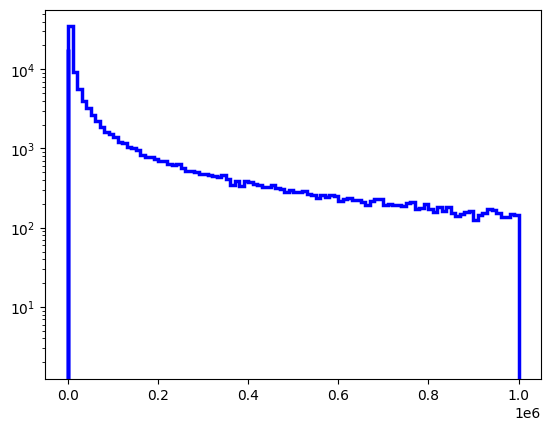

In [22]:
import matplotlib.pyplot as plt
plt.hist(np.array(d2['incident_energies']), bins=100, log=True, histtype='step', linewidth=2.5, color="b")
plt.hist(norm_shower[0], bins=300, log=True, histtype='step', linewidth=2.5, color="b")

(array([34841.,  9273.,  5652.,  3975.,  3257.,  2610.,  2246.,  1855.,
         1632.,  1513.,  1381.,  1221.,  1178.,  1047.,  1020.,   957.,
          828.,   773.,   787.,   740.,   705.,   688.,   637.,   625.,
          638.,   560.,   524.,   526.,   504.,   472.,   482.,   468.,
          445.,   432.,   468.,   413.,   345.,   394.,   335.,   385.,
          375.,   356.,   345.,   327.,   322.,   348.,   318.,   305.,
          283.,   300.,   285.,   284.,   290.,   269.,   260.,   236.,
          260.,   244.,   257.,   249.,   215.,   230.,   235.,   224.,
          223.,   211.,   194.,   219.,   233.,   232.,   194.,   197.,
          192.,   196.,   189.,   204.,   209.,   173.,   178.,   198.,
          170.,   159.,   185.,   163.,   184.,   155.,   142.,   151.,
          159.,   164.,   124.,   145.,   154.,   170.,   169.,   152.,
          138.,   135.,   147.,   143.]),
 array([-0.63285149, -0.58857211, -0.54429274, -0.50001337, -0.45573399,
        -0.41145462, 

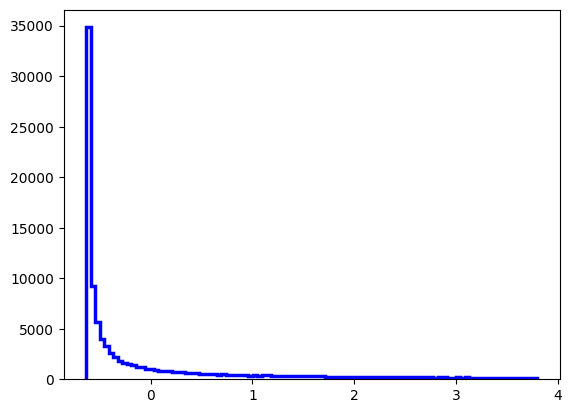

In [17]:
transformer = StandardScaler().fit(inc_energies)
nparr = transformer.transform(inc_energies)

plt.hist(nparr, bins=100, log=False, histtype='step', linewidth=2.5, color="b")

In [1]:
hdfs = [gf,pf]
nplcats = []

#Reshape and concat voxel data
for hdf in hdfs:
    # Takes data from 'voxels' key in the hdf data file
    npl0 = np.array(hdf['voxels'])
    print(npl0, npl0.shape)
    # Converts n > 2 dim to 2 dim, with -1 as a product of all dim > 1
    npl0 = npl0.reshape(npl0.shape[0], -1)
    print(npl0, npl0.shape)
    npcat = np.concatenate([npl0], axis=1)
    print("npcat: ", npcat, npcat.shape)
    nplcats.append(np.concatenate([npl0], axis=1))
    
nplcatscaled = []
transformers = []
arrmins = [[], [], []]
epsilon = 1e-2

for i in range(len(nplcats)):
    nparr = nplcats[i]
#     print("nplcats size: ", nparr.shape)
    
    # replaces non positive values with NaN to use StandardScalar
    nparr = np.where(nparr > 0., nparr, np.nan)
    # gets mean and std of nparr for each column
    transformer = StandardScaler().fit(nparr)
    # transforms nparr to 0 mean and unit variance
    nparr = transformer.transform(nparr)
    transformers.append(transformer)
    
    nparr = np.where(np.isnan(nparr), np.inf, nparr)
    
    for j in range(nparr.shape[1]):
        arrmin = np.amin(nparr[:, j])
        
        # check for negative values in each column (1st voxel of all events in the dataset)
        # different scaling (arrmin) for each voxel in the same shower -> lead to different energy differences between voxels in the same shower?
        # Performing a scaling to epsilon then standardizing the distribution should be better while maintaining correct energy differences and voxel sparsity
        # Note: Maintains energy differences but not same energy ratios before standardization
        # Can Try: Maintaining a normal distribution with same energy ratios and sparsity index by -> finding the min of distribution (standardized epsilon)
        # with consistent energy ratios that satisfy an averaged mean distribution
        if arrmin < 0 and not np.isnan(arrmin):
            nparr[:, j] -= arrmin
            nparr[:, j] += epsilon
            arrmins[i].append(arrmin)
        else:
            arrmins[i].append(0.)
            
    nparr = np.where(np.isinf(nparr), 0, nparr)
    
    # Double checks?
    for j in range(nparr.shape[1]):
        arrmin = np.amin(nparr[:, j])
        if arrmin < 0:
            print(j, arrmin)
            
    nplcatscaled.append(nparr)
    
# Testing Implementation of Preprocessing with Incident Energy Encoding

# transformers = []


# showers_norm = []
# delta = 1e-6

# for i in range(showers.shape[0]):
#     energy_norm.append(showers[i] / energy_inc[i])
#     x = delta + (1 - 2 * delta) * energy_norm
#     logit = np.log(x / (1 - x))

# transformer = StandardScaler().fit(energy_norm)
# nparr = transformer.transform(nparr)
# transformers.append(transformer)    

# log_energy_inc = np.log(energy_inc)
# energy_norm = (log_energy_inc - min(log_energy_inc)) / (max(log_energy_inc) - min(log_energy_inc))

NameError: name 'gf' is not defined

In [55]:
# of datasets (hdf files), # of showers in the first dataset gf, # of showers in the second dataset pf
print(nplcats, len(nplcats), len(nplcats[0]), len(nplcats[1]))
print(nplcatscaled)
print(transformers)
print("arrmins: ", arrmins)

print(np.array(gf['energy']))
print(np.array(gf['energy_from_voxels']), min(np.array(gf['energy_from_voxels'])), max(np.array(gf['energy_from_voxels'])))

# nplcatscaled_t = np.array(nplcatscaled, dtype=np.int16)
# transformers = np.array(transformers, dtype=np.int16)
# arrmins = np.array(arrmins, dtype=np.int16)

[array([[ 80.3099 ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   4.76924,
          0.     ],
       [110.619  ,   0.     ,   3.5489 , ...,   0.     ,   0.     ,
          0.     ],
       ...,
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [529.086  , 298.511  , 268.111  , ...,   0.     ,   0.     ,
          0.     ],
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ]]), array([[ 0.    ,  0.    , 43.6268, ...,  0.    ,  0.    ,  0.    ],
       [37.4615,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [36.148 ,  0.    ,  0.    , ..., 11.3977, 34.0867,  0.    ],
       ...,
       [34.3629,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [33.8369,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ],
       [36.1434,  0.    ,  0.    , ...,  0.    ,  0.    ,  0.    ]])] 2 99933 99999
[array([[0.53474456, 

In [35]:
gf_scaled = h5py.File('/raid/javier/Datasets/CaloVAE/data/atlas_scaled/photons_samples_highStat_En_5.hdf5', 'w')
pf_scaled = h5py.File('/raid/javier/Datasets/CaloVAE/data/atlas_scaled/pions_samples_highStat_En_5.hdf5', 'w')


In [36]:

hdfs_scaled = [gf_scaled, pf_scaled]
# hdfs_scaled = [ef_scaled, gf_scaled, pf_scaled]
layer_shapes = {}
for hdf in hdfs:
    for key in hdf.keys():
        if key == "energy" or key == "overflow" or key == "energy_from_voxels":
            pass
        else:
#             layer_shapes[key] = hdf[key].shape
            layer_shapes[hdf] = {key : hdf[key].shape}
        
        

for hdf, hdf_scaled, scaled_data in zip(hdfs, hdfs_scaled, nplcatscaled):
    offset = 0
    for key in hdf.keys():
        if key == "energy" or key == "overflow" or key == "energy_from_voxels":
            hdf_scaled.create_dataset(key, data=hdf[key])
        else:
            layer_shape = layer_shapes[hdf][key]
            print("###########")
            print(layer_shape)
            print(scaled_data.shape)
#             layer_data = scaled_data[:, offset:offset+(layer_shape[1]*layer_shape[2])]
            layer_data = scaled_data[:, offset:offset+layer_shape[1]]
            print(layer_data.shape)
            layer_data = layer_data.reshape(layer_shape)
            hdf_scaled.create_dataset(key, data=layer_data)
#             offset += layer_shape[1]*layer_shape[2]
            offset += layer_shape[1]



###########
(99933, 368)
(99933, 368)
(99933, 368)
###########
(99999, 533)
(99999, 533)
(99999, 533)


In [37]:
for hdf_scaled in hdfs_scaled:
    for key in hdf_scaled.keys():
        print(key, hdf_scaled[key].shape, hdf_scaled[key].dtype)
        
for hdf_scaled in hdfs_scaled:
    hdf_scaled.close()
    
    


energy (99933, 1) float64
energy_from_voxels (99933, 1) float64
voxels (99933, 368) float64
energy (99999, 1) float64
energy_from_voxels (99999, 1) float64
voxels (99999, 533) float64


In [38]:
# Inverse transform


nplcatinv = []

for i in range(len(nplcatscaled)):
    nparr = nplcatscaled[i]
    nparr = np.where(nparr > 0., nparr, np.nan)
    
    for j in range(nparr.shape[1]):
        arrmin = arrmins[i][j]
        if arrmin < 0. and not np.isnan(arrmin):
            nparr[:, j] -= epsilon
            nparr[:, j] += arrmin
            
    transformer = transformers[i]
    nparr = transformer.inverse_transform(nparr)
    
    nparr = np.where(np.isinf(nparr), 0, nparr)
    nplcatinv.append(nparr)


for i in range(len(nplcatinv)):
    nparrorig = nplcats[i]
    nparrinv = nplcatinv[i]
    
    for j in range(nparrorig.shape[1]):
        diff = np.sum(nparrorig[:, j] - nparrinv[:, j])
        if diff > 0:
            print(i, j, diff)
            
params = transformers[0].get_params()



In [ ]:
gf_scaled = h5py.File('/raid/javier/Datasets/CaloVAE/data/atlas_scaled/photons_samples_highStat_En_5.hdf5', 'w')
pf_scaled = h5py.File('/raid/javier/Datasets/CaloVAE/data/atlas_scaled/pions_samples_highStat_En_5.hdf5', 'w')

In [39]:
import joblib

# joblib.dump(transformers[0], 'scaler.gz')
# transformer = joblib.load('scaler.gz')

joblib.dump(transformers[0], '/raid/javier/Datasets/CaloVAE/data/atlas_scaled/photons_samples_highStat_En_5_scaler.gz')
joblib.dump(transformers[1], '/raid/javier/Datasets/CaloVAE/data/atlas_scaled/pions_samples_highStat_En_5_scaler.gz')



['/raid/javier/Datasets/CaloVAE/data/atlas_scaled/pions_samples_highStat_En_5_scaler.gz']

In [40]:
ld_transformers = []
ld_transformers.append(joblib.load('/raid/javier/Datasets/CaloVAE/data/atlas_scaled/photons_samples_highStat_En_5_scaler.gz'))
ld_transformers.append(joblib.load('/raid/javier/Datasets/CaloVAE/data/atlas_scaled/pions_samples_highStat_En_5_scaler.gz'))

nplcatinv = []

for i in range(len(nplcatscaled)):
    nparr = nplcatscaled[i]
    nparr = np.where(nparr > 0., nparr, np.inf)
    
    for j in range(nparr.shape[1]):
        arrmin = arrmins[i][j]
        if arrmin < 0. and not np.isnan(arrmin):
            nparr[:, j] -= epsilon
            nparr[:, j] += arrmin
            
    transformer = ld_transformers[i]
    nparr = transformer.inverse_transform(nparr)
    
    nparr = np.where(np.isnan(nparr), 0, nparr)
    nplcatinv.append(nparr)
    


In [41]:
for i in range(len(nplcatinv)):
    nparrorig = nplcats[i]
    nparrinv = nplcatinv[i]
    
    for j in range(nparrorig.shape[1]):
        diff = np.sum(nparrorig[:, j] - nparrinv[:, j])
        if diff > 1e-4:
            print(i, j, diff)
            


In [42]:
for i, ptype in enumerate(["photons_samples_highStat_En_5", "pions_samples_highStat_En_5"]):
    filepath = "/raid/javier/Datasets/CaloVAE/data/atlas_scaled/" + ptype + "_amin.npy"
    with open(filepath, 'wb') as f:
        np.save(f, arrmins[i])

In [ ]:
# ATLAS ds 2

In [4]:
gf = h5py.File("/fast_scratch/QVAE/data/atlas_dataset2and3_uniform/dataset_2_1.hdf5", 'r')

In [5]:
hdfs = [gf]
nplcats = []

for hdf in hdfs:
    npl0 = np.array(hdf['showers'])
    
    npl0 = npl0.reshape(npl0.shape[0], -1)
    
    nplcats.append(np.concatenate([npl0], axis=1))
    
nplcatscaled = []
transformers = []
arrmins = [[], [], []]
epsilon = 1e-2

for i in range(len(nplcats)):
    nparr = nplcats[i]
    nparr = np.where(nparr > 0., nparr, np.nan)
    transformer = StandardScaler().fit(nparr)
    nparr = transformer.transform(nparr)
    transformers.append(transformer)
    
    nparr = np.where(np.isnan(nparr), np.inf, nparr)
    
    for j in range(nparr.shape[1]):
        arrmin = np.amin(nparr[:, j])
        
        if arrmin < 0 and not np.isnan(arrmin):
            nparr[:, j] -= arrmin
            nparr[:, j] += epsilon
            arrmins[i].append(arrmin)
        else:
            arrmins[i].append(0.)
            
    nparr = np.where(np.isinf(nparr), 0, nparr)
    
    for j in range(nparr.shape[1]):
        arrmin = np.amin(nparr[:, j])
        if arrmin < 0:
            print(j, arrmin)
            
    nplcatscaled.append(nparr)
    


In [6]:
gf_scaled = h5py.File("/fast_scratch/QVAE/data/atlas_dataset2and3_scaled/uniform_dataset_2_1.hdf5", 'w')
# pf_scaled = h5py.File('/raid/javier/Datasets/CaloVAE/data/atlas_scaled/pions_samples_highStat_En_5.hdf5', 'w')


In [7]:

hdfs_scaled = [gf_scaled]
# hdfs_scaled = [ef_scaled, gf_scaled, pf_scaled]
layer_shapes = {}
for hdf in hdfs:
    for key in hdf.keys():
        if key == "energy" or key == "overflow" or key == "energy_from_voxels":
            pass
        else:
#             layer_shapes[key] = hdf[key].shape
            layer_shapes[hdf] = {key : hdf[key].shape}
        
        

for hdf, hdf_scaled, scaled_data in zip(hdfs, hdfs_scaled, nplcatscaled):
    offset = 0
    for key in hdf.keys():
        if key == "energy" or key == "overflow" or key == "energy_from_voxels" or key == "incident_energies":
            hdf_scaled.create_dataset(key, data=hdf[key])
        else:
            layer_shape = layer_shapes[hdf][key]
            print("###########")
            print(layer_shape)
            print(scaled_data.shape)
#             layer_data = scaled_data[:, offset:offset+(layer_shape[1]*layer_shape[2])]
            layer_data = scaled_data[:, offset:offset+layer_shape[1]]
            print(layer_data.shape)
            layer_data = layer_data.reshape(layer_shape)
            hdf_scaled.create_dataset(key, data=layer_data)
#             offset += layer_shape[1]*layer_shape[2]
            offset += layer_shape[1]



###########
(15924, 6480)
(15924, 6480)
(15924, 6480)


In [8]:
for hdf_scaled in hdfs_scaled:
    for key in hdf_scaled.keys():
        print(key, hdf_scaled[key].shape, hdf_scaled[key].dtype)
        
for hdf_scaled in hdfs_scaled:
    hdf_scaled.close()
    
    


incident_energies (15924, 1) float64
showers (15924, 6480) float64


In [9]:
# Inverse transform


nplcatinv = []

for i in range(len(nplcatscaled)):
    nparr = nplcatscaled[i]
    nparr = np.where(nparr > 0., nparr, np.nan)
    
    for j in range(nparr.shape[1]):
        arrmin = arrmins[i][j]
        if arrmin < 0. and not np.isnan(arrmin):
            nparr[:, j] -= epsilon
            nparr[:, j] += arrmin
            
    transformer = transformers[i]
    nparr = transformer.inverse_transform(nparr)
    
    nparr = np.where(np.isinf(nparr), 0, nparr)
    nplcatinv.append(nparr)


for i in range(len(nplcatinv)):
    nparrorig = nplcats[i]
    nparrinv = nplcatinv[i]
    
    for j in range(nparrorig.shape[1]):
        diff = np.sum(nparrorig[:, j] - nparrinv[:, j])
        if diff > 0:
            print(i, j, diff)
            
params = transformers[0].get_params()



In [10]:
# gf_scaled = h5py.File('/raid/javier/Datasets/CaloVAE/data/atlas_dataset2and3_scaled/dataset_2_1.hdf5', 'w')
# pf_scaled = h5py.File('/raid/javier/Datasets/CaloVAE/data/atlas_scaled/pions_samples_highStat_En_5.hdf5', 'w')

In [11]:
import joblib

# joblib.dump(transformers[0], 'scaler.gz')
# transformer = joblib.load('scaler.gz')

joblib.dump(transformers[0], '/fast_scratch/QVAE/data/atlas_dataset2and3_scaled/uniform_dataset_2_1_scaler.gz')
# joblib.dump(transformers[1], '/raid/javier/Datasets/CaloVAE/data/atlas_scaled/pions_samples_highStat_En_5_scaler.gz')



['/fast_scratch/QVAE/data/atlas_dataset2and3_scaled/uniform_dataset_2_1_scaler.gz']

In [12]:
ld_transformers = []
ld_transformers.append(joblib.load('/fast_scratch/QVAE/data/atlas_dataset2and3_scaled/uniform_dataset_2_1_scaler.gz'))
# ld_transformers.append(joblib.load('/raid/javier/Datasets/CaloVAE/data/atlas_scaled/pions_samples_highStat_En_5_scaler.gz'))

nplcatinv = []

for i in range(len(nplcatscaled)):
    nparr = nplcatscaled[i]
    # nparr = np.where(nparr > 0., nparr, np.inf)
    nparr = np.where(nparr > 0., nparr, np.nan)
    
    for j in range(nparr.shape[1]):
        arrmin = arrmins[i][j]
        if arrmin < 0. and not np.isnan(arrmin):
            nparr[:, j] -= epsilon
            nparr[:, j] += arrmin
            
    transformer = ld_transformers[i]
    nparr = transformer.inverse_transform(nparr)
    
    # nparr = np.where(np.isnan(nparr), 0, nparr)
    nparr = np.where(np.isnan(nparr), 0, nparr)
    nplcatinv.append(nparr)
    


In [13]:
for i in range(len(nplcatinv)):
    nparrorig = nplcats[i]
    nparrinv = nplcatinv[i]
    
    for j in range(nparrorig.shape[1]):
        diff = np.sum(nparrorig[:, j] - nparrinv[:, j])
        if diff > 1e-4:
            print(i, j, diff)
            


In [14]:
for i, ptype in enumerate(["dataset_2_1"]):
    filepath = "/fast_scratch/QVAE/data/atlas_dataset2and3_scaled/uniform_" + ptype + "_amin.npy"
    with open(filepath, 'wb') as f:
        np.save(f, arrmins[i])